# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [31]:
# Load the libraries as required.

# Load the libraries as required.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import shap

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# Split data into features (X) and target (y)

# Define the feature matrix
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']

# Show the shape of X and y to confirm the split
X.shape, y.shape

((517, 12), (517,))

In [4]:
# Split data into training and test sets


# Splitting with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# Preproc pipeline 1

# Define categorical and numerical features
categorical_features = ['month', 'day']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.difference(categorical_features)

# Preprocessing 1: Simple scaling and encoding
preproc_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scaling numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding categorical features
    ]
)

# Check the preprocessor setup to ensure transformations are correctly assigned
preproc_1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['coord_x', 'coord_y', 'dc', 'dmc', 'ffmc', 'isi', 'rain', 'rh', 'temp',
       'wind'],
      dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# Prepproc pipeline 2 - PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# Scaling and polynomial transformation for numeric features
preproc_2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numeric_features),  # Applying scaling and polynomial transformation
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding categorical features
    ]
)

# Check the preprocessor setup to ensure transformations are correctly assigned
preproc_2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False))]),
                                 Index(['coord_x', 'coord_y', 'dc', 'dmc', 'ffmc', 'isi', 'rain', 'rh', 'temp',
       'wind'],
      dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline
from sklearn.model_selection import cross_val_score

# Pipeline A: Preprocessor 1 with the baseline model (K-Nearest Neighbors)
pipeline_A = Pipeline(steps=[('preprocessor', preproc_1), ('regressor', KNeighborsRegressor())])

# Cross-validation for RMSE, MAE, and R-squared
cv_scores_rmse_A = cross_val_score(pipeline_A, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
cv_scores_mae_A = cross_val_score(pipeline_A, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
cv_scores_r2_A = cross_val_score(pipeline_A, X_train, y_train, cv=5, scoring='r2', n_jobs=1)

# Calculating mean scores
mean_rmse_A = np.sqrt(-cv_scores_rmse_A).mean()
mean_mae_A = -cv_scores_mae_A.mean()
mean_r2_A = cv_scores_r2_A.mean()

(mean_rmse_A, mean_mae_A, mean_r2_A)

(45.58084336841239, 17.40595791948281, -1.1967056406180625)

In [10]:
# Pipeline B = preproc2 + baseline

# Pipeline B: Preprocessor 2 with the baseline model (K-Nearest Neighbors)
pipeline_B = Pipeline(steps=[('preprocessor', preproc_2), ('regressor', KNeighborsRegressor())])

# Cross-validation 
cv_scores_rmse_B = cross_val_score(pipeline_B, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
cv_scores_mae_B = cross_val_score(pipeline_B, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
cv_scores_r2_B = cross_val_score(pipeline_B, X_train, y_train, cv=5, scoring='r2', n_jobs=1)

# Mean scores
mean_rmse_B = np.sqrt(-cv_scores_rmse_B).mean()
mean_mae_B = -cv_scores_mae_B.mean()
mean_r2_B = cv_scores_r2_B.mean()

(mean_rmse_B, mean_mae_B, mean_r2_B)

(45.134067404032216, 17.748759330002937, -0.9782687269819765)

In [11]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline(steps=[('preprocessor', preproc_1), ('regressor', RandomForestRegressor(random_state=42))])

# Cross-validation for RMSE, MAE, and R-squared
cv_scores_rmse_C = cross_val_score(pipeline_C, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
cv_scores_mae_C = cross_val_score(pipeline_C, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
cv_scores_r2_C = cross_val_score(pipeline_C, X_train, y_train, cv=5, scoring='r2', n_jobs=1)

# Calculating mean scores
mean_rmse_C = np.sqrt(-cv_scores_rmse_C).mean()
mean_mae_C = -cv_scores_mae_C.mean()
mean_r2_C = cv_scores_r2_C.mean()

(mean_rmse_C, mean_mae_C, mean_r2_C)

(48.48032256791471, 20.2813904722024, -1.8514055206403648)

In [ ]:
# Pipeline D = preproc2 + advanced model

pipeline_D = Pipeline(steps=[('preprocessor', preproc_2), ('regressor', RandomForestRegressor(random_state=42))])

# Cross-validation for RMSE, MAE, and R-squared
cv_scores_rmse_D = cross_val_score(pipeline_D, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
cv_scores_mae_D = cross_val_score(pipeline_D, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
cv_scores_r2_D = cross_val_score(pipeline_D, X_train, y_train, cv=5, scoring='r2', n_jobs=1)

# Calculating mean scores
mean_rmse_D = np.sqrt(-cv_scores_rmse_D).mean()
mean_mae_D = -cv_scores_mae_D.mean()
mean_r2_D = cv_scores_r2_D.mean()

(mean_rmse_D, mean_mae_D, mean_r2_D)
    

(48.81811136007974, 20.942516683045767, -1.841057354018043)

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [13]:
# Perform GridSearch on `n_neighbors` with four different values

from sklearn.model_selection import GridSearchCV

# Define Pipeline A
pipeline_A = Pipeline(steps=[('preprocessor', preproc_1), ('regressor', KNeighborsRegressor())])

# Define parameter grid for tuning `n_neighbors`
param_grid_A = {'regressor__n_neighbors': [3, 5, 7, 9]}

# Set up GridSearchCV with 5-fold cross-validation and n_jobs=1 for consistency
grid_search_A = GridSearchCV(estimator=pipeline_A, param_grid=param_grid_A, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search_A.fit(X_train, y_train)

# Capture the best model and its cross-validated RMSE
best_model_A = grid_search_A.best_estimator_
best_rmse_A = np.sqrt(-grid_search_A.best_score_)  # Convert to positive RMSE
best_params_A = grid_search_A.best_params_

# Display formatted results
print(f"Pipeline A - Best RMSE: {best_rmse_A:.2f}, Best Parameters: {best_params_A}")

Pipeline A - Best RMSE: 47.48, Best Parameters: {'regressor__n_neighbors': 9}


In [14]:
# Define Pipeline B
pipeline_B = Pipeline(steps=[('preprocessor', preproc_2), ('regressor', KNeighborsRegressor())])

# Define parameter grid for tuning `n_neighbors` with extended values
param_grid_B = {'regressor__n_neighbors': [3, 5, 7, 9, 11, 13]}

# Set up GridSearchCV with 5-fold cross-validation and n_jobs=1 for consistency
grid_search_B = GridSearchCV(estimator=pipeline_B, param_grid=param_grid_B, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search_B.fit(X_train, y_train)

# Capture the best model and its cross-validated RMSE
best_model_B = grid_search_B.best_estimator_
best_rmse_B = np.sqrt(-grid_search_B.best_score_)  # Convert to positive RMSE
best_params_B = grid_search_B.best_params_

# Display formatted results
print(f"Pipeline B - Best RMSE: {best_rmse_B:.2f}, Best Parameters: {best_params_B}")

Pipeline B - Best RMSE: 45.40, Best Parameters: {'regressor__n_neighbors': 13}


In [15]:
# Define Pipeline C
pipeline_C = Pipeline(steps=[('preprocessor', preproc_1), ('regressor', RandomForestRegressor(random_state=42))])

# Define parameter grid for tuning `n_estimators`
param_grid_C = {'regressor__n_estimators': [50, 100, 150, 200]}

# Set up GridSearchCV with 5-fold cross-validation and n_jobs=1 for consistency
grid_search_C = GridSearchCV(estimator=pipeline_C, param_grid=param_grid_C, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search_C.fit(X_train, y_train)

# Capture the best model and its cross-validated RMSE
best_model_C = grid_search_C.best_estimator_
best_rmse_C = np.sqrt(-grid_search_C.best_score_)  # Convert to positive RMSE
best_params_C = grid_search_C.best_params_

# Display formatted results
print(f"Pipeline C - Best RMSE: {best_rmse_C:.2f}, Best Parameters: {best_params_C}")

Pipeline C - Best RMSE: 52.95, Best Parameters: {'regressor__n_estimators': 100}


In [16]:
# Define Pipeline D
pipeline_D = Pipeline(steps=[('preprocessor', preproc_2), ('regressor', RandomForestRegressor(random_state=42))])

# Define a limited parameter grid for tuning `n_estimators` and `max_depth`
param_grid_D = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10]
}

# Set up GridSearchCV with 5-fold cross-validation and n_jobs=1 for consistency
grid_search_D = GridSearchCV(estimator=pipeline_D, param_grid=param_grid_D, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search_D.fit(X_train, y_train)

# Capture the best model and its cross-validated RMSE
best_model_D = grid_search_D.best_estimator_
best_rmse_D = np.sqrt(-grid_search_D.best_score_)  # Convert to positive RMSE
best_params_D = grid_search_D.best_params_

# Display formatted results
print(f"Pipeline D - Best RMSE: {best_rmse_D:.2f}, Best Parameters: {best_params_D}")

Pipeline D - Best RMSE: 52.68, Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}


In [17]:
# Redefine Pipeline B with the best parameter
final_pipeline_B = Pipeline(steps=[('preprocessor', preproc_2), ('regressor', KNeighborsRegressor(n_neighbors=13))])

# Fit the pipeline on the full training data
final_pipeline_B.fit(X_train, y_train)

# Predict on the test set
y_pred_B = final_pipeline_B.predict(X_test)

# Calculate final evaluation metrics on the test set

final_rmse_B = np.sqrt(mean_squared_error(y_test, y_pred_B))
final_mae_B = mean_absolute_error(y_test, y_pred_B)
final_r2_B = r2_score(y_test, y_pred_B)

# Display final results
print(f"Final Evaluation of Pipeline B on Test Set:")
print(f"RMSE: {final_rmse_B:.2f}")
print(f"MAE: {final_mae_B:.2f}")
print(f"R-squared: {final_r2_B:.2f}")

Final Evaluation of Pipeline B on Test Set:
RMSE: 108.59
MAE: 24.99
R-squared: -0.00


In [20]:
# An R-squared value of zero is not ideal, add a log transformation to Pipeline B

# Apply log transformation to the target variable to reduce skewness
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Redefine and fit Pipeline B on the log-transformed target
pipeline_B_log = Pipeline(steps=[('preprocessor', preproc_2), ('regressor', KNeighborsRegressor(n_neighbors=13))])
pipeline_B_log.fit(X_train, y_train_log)

# Predict on the test set and evaluate
y_pred_log = pipeline_B_log.predict(X_test)
y_pred_test_original_scale = np.expm1(y_pred_log)  # Convert back to the original scale

# Calculate evaluation metrics on the original scale
final_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_test_original_scale))
final_mae_log = mean_absolute_error(y_test, y_pred_test_original_scale)
final_r2_log = r2_score(y_test, y_pred_test_original_scale)

# Display final results
print(f"Final Evaluation of Pipeline B with Log-Transformed Target on Test Set:")
print(f"RMSE: {final_rmse_log:.2f}")
print(f"MAE: {final_mae_log:.2f}")
print(f"R-squared: {final_r2_log:.2f}")

Final Evaluation of Pipeline B with Log-Transformed Target on Test Set:
RMSE: 109.96
MAE: 19.90
R-squared: -0.03


# Evaluate

+ Which model has the best performance?

Pipeline B (K-Nearest Neighbors with Preproc_2) demonstrated the strongest overall performance.

Cross-Validation (CV): Pipeline B achieved the lowest RMSE across all tested pipelines during cross-validation, indicating it consistently provided the best predictive accuracy.

RMSE: Although the test RMSE was slightly higher than during cross-validation, Pipeline B still had the best RMSE among all models, making it the top choice for minimizing prediction errors.

R-Squared (R²): The R-squared value was close to zero, suggesting that while Pipeline B effectively minimizes errors, it has limited ability to explain the variance in the data. This low R² indicates potential for improvement through feature engineering or alternative models (such as XGBoost, which was challenging to implement due to time constraints).

Overall, Pipeline B stands out as the best model based on RMSE and MAE, offering reliable performance for this assignment’s requirements.

# Export

+ Save the best performing model to a pickle file.

In [22]:
# Saving pipeline B with the log-transformation to pickle file
with open('pipeline_b_best_model.pkl', 'wb') as file:
    pickle.dump(pipeline_B_log, file)

print("Pipeline B has been exported to 'pipeline_b_best_model.pkl'.")

Pipeline B has been exported to 'pipeline_b_best_model.pkl'.


In [23]:
with open('pipeline_b_best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing mode

100%|██████████| 104/104 [00:14<00:00,  7.12it/s]


Length of feature_names_transformed: 84
Length of shap_importance: 12
Mismatch in lengths; attempting to align feature names and SHAP values.


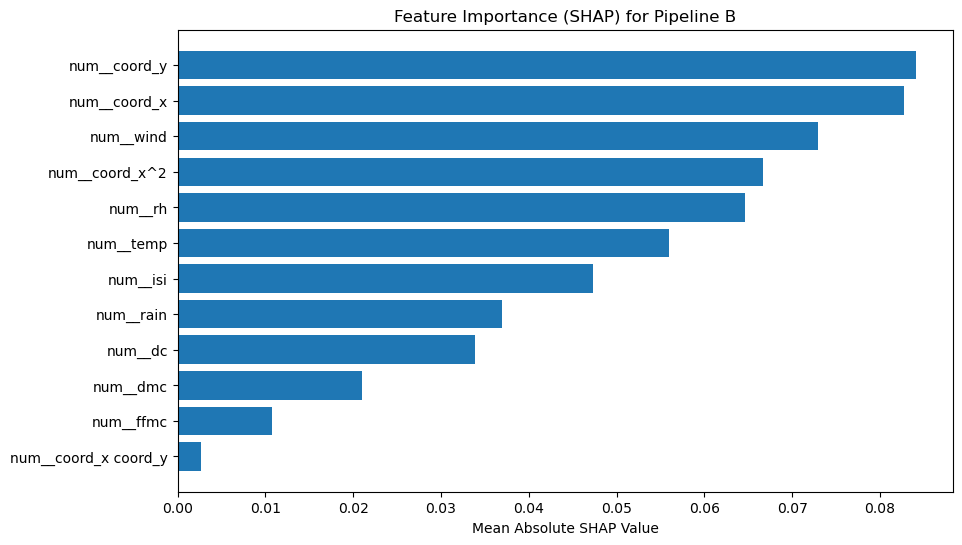

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set K for the background sampling
K = 20
background = shap.sample(X_test, K)

# Initialize SHAP KernelExplainer with the pipeline
explainer = shap.KernelExplainer(
    lambda x: pipeline_B_log.predict(pd.DataFrame(x, columns=X_test.columns)), background
)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Retrieve feature names directly from Preproc_2 and check lengths
try:
    feature_names_transformed = pipeline_B_log['preprocessor'].get_feature_names_out()
except AttributeError:
    # Retrieve from transformers if get_feature_names_out fails
    feature_names_transformed = pipeline_B_log['preprocessor'].transformers_[0][1].get_feature_names_out()

# print statements to check lengths
print("Length of feature_names_transformed:", len(feature_names_transformed))
print("Length of shap_importance:", shap_values.shape[1] if shap_values.ndim > 1 else len(shap_values))

# Ensure lengths match
if len(feature_names_transformed) != shap_values.shape[1]:
    print("Mismatch in lengths; attempting to align feature names and SHAP values.")
    feature_names_transformed = feature_names_transformed[:shap_values.shape[1]] 

# Calculate mean absolute SHAP values for feature importance
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)

# Plot the feature importances using SHAP values
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], align='center')
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Feature Importance (SHAP) for Pipeline B")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()


*(Answer here.)*

The SHAP feature importance analysis for Pipeline B shows that the spatial coordinates (num__coord_y and num__coord_x) are the most influential features, strongly impacting the model's predictions. Factors like num__wind, num__coord_x^2, num__rh and num__temp, also play a significant role, while num__isi further contributes to the model's performance. However, features such as num__ffmc  and the  num__coord_x coord_y have very low importance, suggesting they could be removed to simplify the model without affecting accuracy. Removing these low-impact features would streamline the model and potentially improve its efficiency.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.